# Analyze A/B Test Results 

This notebook is organized into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. This project works with the results of an A/B test run by an e-commerce website. The goal of this project is to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#Setting the seed to assure get the same answers on quizzes on Udacity
random.seed(42)

### ToDo 1.1
Below is the description of `ab_data.csv` data, there are a total of 5 columns:
<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Number of rows in the dataset.

In [3]:
len(df)

294478

**c.** The number of unique users in the dataset.

In [4]:
user_num = len(df['user_id'].drop_duplicates())
user_num

290584

**d.** The proportion of users converted.

In [5]:
user = df[['user_id', 'converted']].drop_duplicates()
user_converted = user.groupby('converted')['user_id'].count()/user_num
user_converted[1]

0.12104245244060237

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
check = df.query('(group == "treatment" & landing_page != "new_page") or (group != "treatment" & landing_page == "new_page")')
len(check)

3893

**f.** Do any of the rows have missing values? No missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, there are rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`. These rows cannot be sure if truly received the new or old wepage.  

**a.** Create new dataframe in **df2** which removes confused records.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.query("(group == 'treatment')&(landing_page == 'new_page') | (group == 'control')&(landing_page == 'old_page')")

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  

**a.** Number of unique **user_id**s in **df2**

In [10]:
len(df2['user_id'].drop_duplicates())

290584

**b.** There is one **user_id** repeated in **df2**

In [11]:
df_user = df2.groupby('user_id')['group'].count()
df_user[df_user > 1]

user_id
773192    2
Name: group, dtype: int64

**c.** Display the rows for the duplicate **user_id**

In [12]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id.
df2 = df2.drop_duplicates(keep='last')
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### ToDo 1.4  

**a.** The probability of an individual converting regardless of the page they receive

In [14]:
user2 = df2[['user_id', 'converted']].drop_duplicates()
user2_converted = user2.groupby('converted')['user_id'].count()/len(df2['user_id'].drop_duplicates())
p_pop = user2_converted[1]
p_pop

0.11959708724499628

**b.** The probability of an individual converting in the `control` group

In [15]:
user_control = df2[df2['group'] == 'control'].groupby('converted')['user_id'].count()/len(df2[df2['group'] == 'control']['user_id'].drop_duplicates())
user_control_converted = user_control[1]
user_control_converted

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
user_treatment = df2[df2['group'] == 'treatment'].groupby('converted')['user_id'].count()/len(df2[df2['group'] == 'treatment']['user_id'].drop_duplicates())
user_treatment_converted = user_treatment[1]
user_treatment_converted

0.11880806551510564

In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = user_treatment_converted - user_control_converted
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [18]:
user_group = df2[['user_id', 'group']].drop_duplicates()
user_group_percentage = user_group.groupby('group')['user_id'].count()/len(df2['user_id'].drop_duplicates())
user_group_percentage_treatment = user_group_percentage[1]
user_group_percentage_treatment

0.5000619442226688

**e.** Conclusion: The new `old` group users lead to *more* conversions.

>**- Conversion rate regardless of the page they receive is 11.96%.
<br>
<br>- Conversion rate of treatment group is 11.88%.
<br>
<br>- Conversion rate of control group is 12.04%.
<br>
<br>- The sample was seperated fairly by haft to control(old) and treatment(new) group so that the probability can be compared.
<br>
<br>- Conversion rate of control group higher than Conversion rate of treatment group by 0.16%, which can indicate quickly that old page is better than new page.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, a hypothesis test cound be run continuously as long as the events are observed. 

However, then the hard questions would be: 
- Should the A/B test be stoped as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long should the A/B test be run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider making the decision just based on all the data provided - the "converted" probability for the old page is *slightly* higher than that of the new page (ToDo 1.4.c).



If the company want to assume that the old page is better, hypothesis test need to be performed with:
- Null hypotheses (**$H_0$**): **$p_{old}$** >= **$p_{new}$**
- Alternative hypotheses (**$H_1$**): **$p_{old}$** < **$p_{new}$**

**$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**a.** The **conversion rate** for $p_{new}$ under the null hypothesis

In [19]:
p_new = p_pop
p_new

0.11959708724499628

**b.** The **conversion rate** for $p_{old}$ under the null hypothesis

In [20]:
p_old = p_pop
p_old

0.11959708724499628

**c.** $n_{new}$, the number of individuals in the treatment group? <br><br>

In [21]:
user_group_number = user_group.groupby('group')['user_id'].nunique()
n_new = user_group_number[1]
n_new

145310

**d.** $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = user_group_number[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [23]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], n_new, p=[1-p_new,p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [24]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], n_old, p=[1-p_old,p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for simulated samples from the parts (e) and (f) above. 

In [25]:
p_new_2 = new_page_converted.sum()/n_new
p_old_2 = old_page_converted.sum()/n_old
diff = p_new_2 - p_old_2
diff

0.0010095933356233794


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [26]:
# Sampling distribution 
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p=[1-p_new,p_new])
    old_page_converted = np.random.choice([0,1], n_old, p=[1-p_old,p_old])
    p_new_2 = new_page_converted.sum()/n_new
    p_old_2 = old_page_converted.sum()/n_old
    diff = p_new_2 - p_old_2
    p_diffs.append(diff)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs** and mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart. <br>

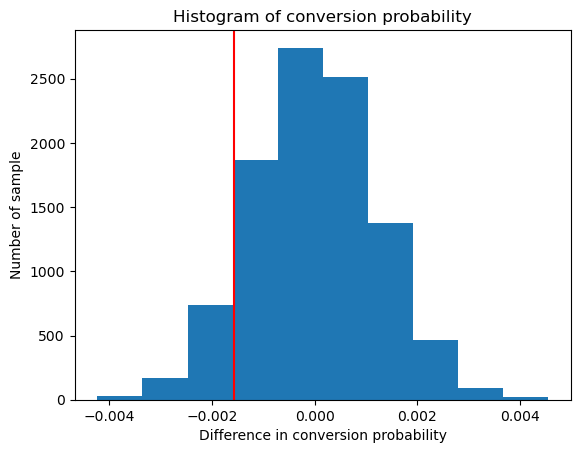

In [27]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color = 'r')
plt.xlabel('Difference in conversion probability')
plt.ylabel('Number of sample')
plt.title('Histogram of conversion probability')
plt.show()

**j.** The proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data

In [28]:
p_value = (p_diffs > obs_diff).mean()
p_value

0.9028

**k.** Conclusion: The null hypothesis is failed to reject, which means there is not a difference between the new and old pages. 

>**- This value (proportion of the p_diffs > the actual difference observed) called "p value" in scientific studies.
<br>
<br>- If the p-value is small (usually less than 0.05), it suggests that null hypothesis is not true. A small p-value suggests that the results are statistically significant, meaning that they are unlikely to have occurred by chance. On the other hand, a large p-value suggests that the results are not statistically significant, meaning that they could have occurred by chance.
<br>
<br>- By comparing p-value to type I error threshold (α = 0.05), decision about which hypothesis is true or there is a difference between the new and old pages or not can be made.
The p-value  = 0.09 >  0.05 (type I error rate), the null hypothesis is failed to reject.**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [29]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2[(df2['group'] == 'control') & (df2['converted'] == 1)]['user_id'].count()

# number of conversions with the new_page
convert_new = df2[(df2['group'] == 'treatment') & (df2['converted'] == 1)]['user_id'].count()

# number of individuals who were shown the old_page
n_old = n_old

# number of individuals who received new_page
n_new = n_new

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org


In [46]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
count_array = np.array([convert_old, convert_new])

nobs_array = np.array([n_old, n_new])

z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative = 'smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


**n.** Conclusion

>**- The p-value (0.095) is similar to the one computed earlier (0.097).
<br>- Accordingly, the null hypothesis also is failed to reject because p-value is greater than the Type I error rate. At the same time, the z-score (1.31) is smaller than z-alpha (1.645) which means z-score do not lie in the "rejection region" and the null hypothesis is not rejected
<br>- This findings agree with the findings earlier in parts j. and k.**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, the result in the A/B test in Part II above can also be achieved by performing regression.

**a.** Type of regression

>**Since each row in the `df2` data is either a conversion or no conversion, logistic regression is used to predict the probability of the occurrence of a binary event based on one or more predictor variables.**

**b.** Use **statsmodels** library to fit the logistic regression model to see if there is a significant difference in conversion based on the page-type a customer receives. First, create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [31]:
df2['intercept'] = 1
df2 = df2.reset_index()
ab_page = []

for i in range(0,len(df2)):
    if df2['group'][i] == 'control':
        ab_page.append(0)
    else:
        ab_page.append(1)
        
df2['ab_page'] = ab_page
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290585 entries, 0 to 290584
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         290585 non-null  int64 
 1   user_id       290585 non-null  int64 
 2   timestamp     290585 non-null  object
 3   group         290585 non-null  object
 4   landing_page  290585 non-null  object
 5   converted     290585 non-null  int64 
 6   intercept     290585 non-null  int64 
 7   ab_page       290585 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 17.7+ MB


**c.** Use **statsmodels** to instantiate regression model on the two columns created above, then fit the model to predict whether or not an individual converts. 


In [32]:
# defining the dependent and independent variables
Xtrain = df2[['intercept', 'ab_page']]
ytrain = df2['converted']
   
# building the model and fitting the data
log_reg = sm.Logit(ytrain,Xtrain)
results = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [33]:
# printing the summary table
print(results.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.6032
Date:               2023-05-11 18:02 BIC:              212801.7625
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290583           LLR p-value:      0.18965    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074



**e.** Conclusion

>  **- The p-value of ab_page  is 0.1897 > 0.05 differing from p value found in Part II (0.09) due to the type of test (part III is a two-sided and Part II is a one-sided)
<br>- However, this p-value is still larger then Type I error rate (0.19 > 0.05) which means the null hypothesis is also failed to reject.**

**f.** Considering other things that might influence decision.

>**- It is a good idea to consider other factors to add into regression model because this help the regression line to be more accurate.
<br>- Disadvantage to adding additional terms into regression model is the results may be mismatched and harder for others to understand.**

**g. Adding countries**<br> 
Along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.

In [34]:
# Read the countries.csv
country = pd.read_csv('countries.csv')

In [35]:
# Join with the df2 dataframe
df3 = df2.merge(country, on='user_id')
df3.head()

,index,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [36]:
# Create the necessary dummy variables
df3 = pd.get_dummies(data=df3, columns=['country'])
df3.head()

,index,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country_CA,country_UK,country_US
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0,1
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,0,1
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,0,1


In [37]:
df3['intercept'] = 1

Xtrain_country = df3[['intercept','ab_page','country_CA','country_UK']]
# ,'country_US']]
ytrain_country = df3['converted']

logit_reg_country = sm.Logit(ytrain_country,Xtrain_country)
result_country = logit_reg_country.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [38]:
result_country.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.3782
Date:               2023-05-11 18:02 BIC:              212823.6968
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.17584    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7629  0.0000  -2.0067  -1.9718
ab_page      -0.0150    0.0114    -1.3076  0.1910  -0.0374   0.0075
country_CA   -0.0408    0.0269    -1.5159  0.1296  -0.0934   0.0119
country_UK    0.0099    0.0133     0.7437  0.4570  -0.0162   0.0359
==================================================================

"""

>**- All of p-values in the summary is greater than Type I error rate (0.05). The null hypotheses (regression model) are failed to reject.
<br>- Country doesn't appear to have an impact on conversion.**

**h. Fit model and obtain the results**<br> 
Look at an interaction between page and country to see if are there significant effects on conversion.

In [39]:
df3['country_CA_ab'] = df3['ab_page']*df3['country_CA']
df3['country_UK_ab'] = df3['ab_page']*df3['country_UK']
df3['country_US_ab'] = df3['ab_page']*df3['country_US']
    
df3.info()
df3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 290584
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   index          290585 non-null  int64 
 1   user_id        290585 non-null  int64 
 2   timestamp      290585 non-null  object
 3   group          290585 non-null  object
 4   landing_page   290585 non-null  object
 5   converted      290585 non-null  int64 
 6   intercept      290585 non-null  int64 
 7   ab_page        290585 non-null  int64 
 8   country_CA     290585 non-null  uint8 
 9   country_UK     290585 non-null  uint8 
 10  country_US     290585 non-null  uint8 
 11  country_CA_ab  290585 non-null  int64 
 12  country_UK_ab  290585 non-null  int64 
 13  country_US_ab  290585 non-null  int64 
dtypes: int64(8), object(3), uint8(3)
memory usage: 27.4+ MB


,index,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country_CA,country_UK,country_US,country_CA_ab,country_UK_ab,country_US_ab
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,0,1,0,0,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,0,1,0,0,0
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,0,0,1
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,0,0,1
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,0,1,0,0,0


In [40]:
Xtrain_country_2 = df3[['intercept','ab_page','country_CA','country_UK','country_CA_ab','country_UK_ab']]
ytrain_country_2 = df3['converted']

logit_reg_country_2 = sm.Logit(ytrain_country_2,Xtrain_country_2)
result_country_2 = logit_reg_country_2.fit()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


In [41]:
result_country_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.9124
Date:               2023-05-11 18:02 BIC:              212846.3903
No. Observations:   290585           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290579           LLR p-value:      0.19182    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9865   0.0096 -206.3440 0.0000 -2.0053 -1.9676
ab_page          -0.0206   0.0137   -1.5060 0.1321 -0.0474  0.0062
country_CA       -0.0175   0.0377   -0.4652 0.6418 -0.0914  0.0563
country_UK       -0.0057   0.0188   -0.3057 0.7598 -0.0426  0.0311
country_CA_ab    -0.0469   0.0538   -0.8716 0.3834 -0.1523  0.0585
country_UK_ab     0.0314   0.0266    1.1811 0.2375 -0.0207  0.0835
==================================================================

"""

>**The p-values for each country is greater than interaction (0.64 > 0.38 for CA and 0.76 > 0.17 for the UK), which means the null hypotheses (regression model) are failed to reject.**

>**The company should keep the old page.**